### Student Information
### This notebook is the third part of lab2.
Name:李昕紘 (LI, HSIN-HUNG)

Student ID: 110013504

GitHub ID: HSIN-HUNG LI

Kaggle name: timleeeee

Kaggle private scoreboard snapshot: Private Rank: #26

![Snapshot](img/pic0.png)

# Third part 
### A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

### 讀取JSON檔案中的資訊，其中包括text, tweed_it 以及 emotion。

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from glom import glom
df_data = pd.read_json('data/tweets_DM.json', lines=True)
df_tweet = pd.DataFrame(list(df_data['_source'].apply(lambda row: glom(row, 'tweet'))))
del df_data


In [39]:
df_emotion = pd.read_csv('data/emotion.csv', sep = ",")
df_sample = pd.read_csv('data/sampleSubmission.csv', sep = ",")
df_train = pd.merge(df_tweet, df_emotion, on='tweet_id')
df_train = df_train.drop(columns=['hashtags'])
df_sample.rename(columns = {'id':'tweet_id'}, inplace = True)
df_train.to_csv('data/train_original.csv') 
df_train.head(3)

,tweet_id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear


### 觀察train以及test_sample的大小，並利用tweet_id來合併sample，但是因為需要做文字前處理，因此先打包輸出成一原始資料檔案。


In [40]:
print('df_train.shape = ')
print(df_train.shape)
print('df_predict.shape = ')
print(df_sample.shape)
df_sample.head(3)

df_train.shape = 
(1455563, 3)
df_predict.shape = 
(411972, 2)


,tweet_id,emotion
0,0x2c7743,surprise
1,0x2c1eed,surprise
2,0x2826ea,surprise


In [41]:
df_predict_original=pd.merge(df_sample, df_tweet,how="left",on="tweet_id")
df_predict_original = df_predict_original.drop(columns=['hashtags'])
df_predict_original.to_csv('data/pred_original.csv') 
df_predict_original.head(3)

,tweet_id,emotion,text
0,0x2c7743,surprise,When your friends offer to bring you food 😭💘 #...
1,0x2c1eed,surprise,I've never let any money problems stop me.. I ...
2,0x2826ea,surprise,@KurtSchlichter Being a Hobby Historian Chelse...


### 將 emotion 改為數字編碼來區分，編碼結果如下，並分析不同類別的數量，可以發現joy異常的多，相較於最少的類別anger，差距10倍以上，但是考量到Kaggle上的test data同樣會有這樣imbalance的問題，因此需要以這樣的比例進行training。

In [42]:
unique_labels = df_train.emotion.unique()
label_dict = {}
for index, possible_label in enumerate(unique_labels):
    label_dict[possible_label] = index
    
df_train['label'] = df_train.emotion.replace(label_dict)
label_dict

{'anticipation': 0,
 'sadness': 1,
 'fear': 2,
 'joy': 3,
 'anger': 4,
 'trust': 5,
 'disgust': 6,
 'surprise': 7}

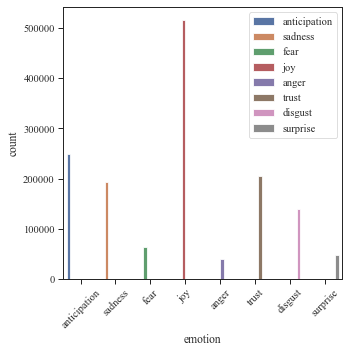

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)   
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman" 
plt.rcParams['figure.figsize'] = (5,5)
# plt.bar(df_train.index,df_train['emotion'])
sns.countplot(x=df_train['emotion'],hue = df_train['emotion'])
plt.legend(loc = 'upper right')
plt.xticks(rotation = 45)
plt.show()

### 檢查 null in text column

In [44]:
print(df_train['text'].isnull().describe())
df_train.head(5)

count     1455563
unique          1
top         False
freq      1455563
Name: text, dtype: object


,tweet_id,text,emotion,label
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,0
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,1
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,2
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy,3
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation,0


### 本作業發現不同類別的資料量具有顯著的差異，而且受限於硬體緣故，因此只能選擇以少量且各類別數量相等來進行訓練。
### 一開始先選擇1000個進行訓練，方便進行程式除錯。

In [45]:
from random import sample
sample_random_state = 11
n_sample = 1000
df_train = df_train.sample(n_sample,random_state = sample_random_state)

In [46]:
df_train.label.value_counts()

3    335
0    185
1    145
5    140
6     86
2     49
7     40
4     20
Name: label, dtype: int64

### 將 train data 分成 training 以及 validation data 用來評估 model 的好壞 

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(df_train.index.values, df_train.label.values, \
                     test_size = 0.15, random_state=17, \
                         stratify = df_train.label.values)

df_train['data_type'] = ['not_set']*df_train.shape[0]
df_train.loc[X_train, 'data_type'] = 'train'
df_train.loc[X_val, 'data_type'] = 'val'
df_train.to_csv('data/train_val_out1.csv') 
df_train.head(10)

,tweet_id,text,emotion,label,data_type
547720,0x24a8df,Off to Fleet services tomorrow to meet a very ...,anticipation,0,train
671567,0x2b7ba8,@WildlifeMag @naturepl Marbled White <LH> unfo...,joy,3,train
780017,0x1fd85f,Haha iSentia down 41% in Aus sharemarket <LH>,disgust,6,train
902802,0x1caa20,So this is kinda sorta maybe the payoff to all...,disgust,6,train
149072,0x226e77,@_kashiaaaxo he really do <LH>,joy,3,train
1231155,0x3772f0,@haanjichandan Happy Diwali to you and your fa...,joy,3,train
1314688,0x2d5aed,Attitude is a little thing that makes a big di...,anticipation,0,train
1240215,0x385b8a,Hey Baby Brain Developme thanks for the follow...,trust,5,train
1145807,0x2e426a,"Look for #opportunities #today to be good, to ...",anticipation,0,val
576065,0x2c1c4e,I may never be rich and famous but the things ...,trust,5,val


### 接下來將進行data preprocessing，主要步驟如下: 
1. 將所有字母轉成小寫。
2.移除所有標點符號，像是!%&\'()*+,-./:;<=>?@[\\]^_{|}~等等。
3. 移除stopwords，這是一種語言中經常出現的詞，例如“the”、“a”等。 可以將它們從文本中刪除，因為它們不會為接下來的整句話提供有價值的信息。
4. 進行Lemmatization，這項工具類似於上課所教學的stemming，但是他確保root word (lemma)是符合該語言的。也因為如此，通常這樣的訓練方式會比stemming來的更久，本作業使用nltk 中的 WordNetLemmatizer。


In [48]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
# nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from tool_function import EMOTICONS, chat_words_str

import re
import emoji
from textblob import TextBlob

def remove_punctuation(text):
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])



def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


In [49]:
df_trainset = pd.read_csv('data/train_val_out1.csv', sep = ",",index_col=0)
def prepreocess1(df_trainset):
    df_trainset = df_trainset.sample(frac=1).reset_index(drop=True)
    df_trainset['text'] = df_trainset['text'].str.lower()
    df_trainset['text'] = df_trainset['text'].apply(lambda text: remove_punctuation(text))
    df_trainset['text'] = df_trainset['text'].apply(lambda text: remove_stopwords(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: lemmatize_words(text))
    return df_trainset
df_trainset = prepreocess1(df_trainset)
df_trainset.to_csv('data/train_prepreocess1.csv') 
# df_predict = prepreocess1(df_predict)
# df_predict.to_csv('data/predict_prepreocess1.csv') 


### data preprocessing，第二步驟如下:
1. 在許多教學中示範刪除表情符號。 但是我認為本作業tweet為情感分析案例，表情符號提供了一些有價值的信息，因此刪除它們可能不是一個好的解決方案。本作業將表情符號轉換為文字格式，以便它們可以用於建模過程中識別，使用emoji.demojize(text)來進行還原。
2. 除了Emoji外，emoticons 也利用1.相同的方式處理。
3.再來則是移除所有URL，因為本作業為推特分析，那麼推文中很有可能會有一些 URL，需要刪除它們以進行進一步分析。
4.除了URL之外，也需要刪除 html 標籤，因為推特有可能從不同網站抓取數據，這將也需要將其移除。
5.推特作為社群軟體，人們在聊天中使用了很多縮寫詞，因此為了我們的分析目的，需要展開並了解這些詞的原文將有所幫助。
6.最後則是進行拼音校正，希望在進行分析之前更正這些拼寫錯誤，本作業使用pyspellchecker 進行拼寫校正。


In [50]:
def convert_emoticons(text):
    
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

from spellchecker import SpellChecker


def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
def chat_words_conversion(text):
    chat_words_map_dict = {}
    chat_words_list = []
    for line in chat_words_str.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [51]:
# df_trainset = pd.read_csv('data/train_prepreocess1.csv', sep = ",",index_col=0)
# df_predict = pd.read_csv('data/predict_prepreocess1.csv', sep = ",",index_col=0)
def prepreocess2(df_trainset):
    df_trainset['text'] = df_trainset["text"].apply(lambda text: convert_emoticons(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: emoji.demojize(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: remove_urls(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: remove_html(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: TextBlob(text))
    df_trainset['text'] = df_trainset["text"].apply(lambda text: chat_words_conversion(text))
    return df_trainset
    
# df_predict = prepreocess2(df_predict)    
# df_predict.to_csv('data/predict_prepreocess2.csv') 

df_trainset = prepreocess2(df_trainset)
df_trainset.to_csv('data/train_prepreocess2.csv') 
df_trainset.head(3)

,tweet_id,text,emotion,label,data_type
0,0x20da91,get suggestion good book pleaseandthankyou goo...,anticipation,0,val
1,0x38f01b,girlsreallyrule insecure men leave nasty vile ...,sadness,1,val
2,0x208a2e,really enjoy see lawrence feel kinda way :smil...,fear,2,train


In [52]:
df_predict_preprocess = pd.read_csv('data/predict_prepreocess2.csv', sep = ",",index_col=0)
df_predict_preprocess=pd.merge(df_sample, df_predict_preprocess,how="left",on="tweet_id")
df_predict_preprocess.to_csv('data/pred_preprocess.csv') 
df_predict_preprocess.head(3)

,tweet_id,emotion_x,text,emotion_y
0,0x2c7743,surprise,friend offer bring food :loudly_crying_face::h...,NaN
1,0x2c1eed,surprise,ive never let money problem stop treat pray li...,NaN
2,0x2826ea,surprise,kurtschlichter hobby historian chelsea let say...,NaN


# Buliding Model

### 在pre-processing 階段發現本作業的資料量過大，因此先隨機挑選各個類別50筆資料來進行訓練，確認模型沒問題後再來增加訓練量

### BERT
本作業首先使用BERT進行處理，BERT是一種由谷歌開發預訓練(pre-training)語言表示的新方法，他在 Sentence Classification 有十分實用的功能，最直接的方法是使用它來對單個文本進行分類，本研究參考: http://jalammar.github.io/illustrated-bert/ 並先使用文本最大長度max_length=256進行encode，接著在截選最適合的max_length。
### 利用 tokenizer.encode 來辨別訓練資料集中的長度，可以發現將max_length設為 100 即可。

Text(0.5, 8.441599999999994, 'Token count')

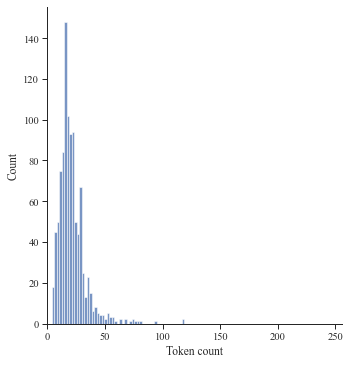

In [54]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch
import pandas as pd
from tqdm.notebook import tqdm
from transformers import logging
logging.set_verbosity_error()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

token_lens = []
for txt in df_trainset.text:
    tokens = tokenizer.encode(txt, max_length=512,truncation=True)
    token_lens.append(len(tokens))
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')


### 將資料切分為train 以及 validation dataset，以此來評估模型的好壞。
### 設定tokenizer.batch_encode_plus以及TensorDataset，並打包成pkl檔案

In [56]:

MAX_LENGTH = 100

encoded_data_train = tokenizer.batch_encode_plus\
    (df_trainset[df_trainset.data_type=='train'].text.values,add_special_tokens=True,\
     return_attention_mask=True,padding=True,\
         max_length=MAX_LENGTH,return_tensors='pt',truncation=True)

encoded_data_val= tokenizer.batch_encode_plus\
    (df_trainset[df_trainset.data_type=='val'].text.values,add_special_tokens=True,\
     return_attention_mask=True,padding=True,\
         max_length=MAX_LENGTH,return_tensors='pt',truncation=True)
        
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_trainset[df_trainset.data_type=='train'].label.values)
        
input_ids_val = encoded_data_val['input_ids']
attention_masks_val= encoded_data_val['attention_mask']
labels_val = torch.tensor(df_trainset[df_trainset.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print('*** len(dataset_train) ***')
print(len(dataset_train))
print('*** len(dataset_val) ***')
print(len(dataset_val))

torch.save(dataset_train, 'data/base_dataset_train.pkl')
torch.save(dataset_val, 'data/base_dataset_val.pkl')

*** len(dataset_train) ***
850
*** len(dataset_val) ***
150


### 設定 BERT Pretrained Model
### 設定 Optimizer and Scheduler，先使用簡單的模型以及少量的batch_size以及epochs，屆時會以其他更高效能電腦進行訓練。

In [58]:
# Setting up BERT Pretrained Model

from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

model = BertForSequenceClassification.from_pretrained\
    ('bert-base-uncased', num_labels = len(label_dict), \
     output_attentions=False,output_hidden_states=False)

batch_size = 32
dataloader_train = DataLoader(dataset_train,sampler=RandomSampler\
                              (dataset_train),batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val,sampler=RandomSampler\
                            (dataset_val),batch_size=batch_size, shuffle=False)


optimizer =  torch.optim.AdamW(model.parameters(),lr=1e-5, #2e-5 > 5e-5 
                 eps=1e-8)
epochs=2

scheduler = get_linear_schedule_with_warmup\
    (optimizer,num_warmup_steps=0,num_training_steps=\
     len(dataloader_train)*epochs)

### 設定Performance Metrics 以及 Training Loop

In [59]:
import numpy as np
from sklearn.metrics import f1_score
import torch
# export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:1280
torch.cuda.empty_cache()

def score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
def class_accuracy(preds, labels):
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
import random

seed_val = 8
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cpu")
model.to(device)

print('*************')
print(device)

*************
cpu


### 開始進行訓練，並記錄loss以及在每一個epoch後儲存model以及利用validation dataset來辨別目前 f1 score。
### 由於訓練的資料量過少，因此F1 score僅有0.17左右。
### 本研究曾經嘗試利用全部近150萬筆資料，但是一個epoch運算時間超過1天，硬體的持有人也需要使用，因此無法配合借我使。因此本研究只能利用近100萬筆資料訓練，但是效果也十分良好，F1 score可以達到0.4835。

In [60]:
import torch
torch.cuda.empty_cache()

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar =  tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),leave=False,disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
            
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch))})
        
    #torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 1.8966368198394776
F1 Score (weighted): 0.1692047377326565


Epoch 2:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 1.8750117778778077
F1 Score (weighted): 0.16666666666666666


### 從validation data來看各類別的準確率可以發現，由於訓練資料過少，且各類別的資料量並不均衡，因此本次的結果十分不理想，模型選擇將所有內容均預測為joy，未來在高效能電腦訓練模型時，應可以有效排除這樣的結果。

In [61]:
_, predictions, true_vals = evaluate(dataloader_val)
class_accuracy(predictions, true_vals )

Class: anticipation
Accuracy: 0/28

Class: sadness
Accuracy: 0/22

Class: fear
Accuracy: 0/7

Class: joy
Accuracy: 50/50

Class: anger
Accuracy: 0/3

Class: trust
Accuracy: 0/21

Class: disgust
Accuracy: 0/13

Class: surprise
Accuracy: 0/6



### 再來則是利用已經完成pre-process的test data來進行預測，首先來觀察資料的型式，可以看到text value已完成訓練，再來則是利用模型進行預測，encoded data的方式與train data 一樣，使用tokenizer.batch_encode_plus以及相同的參數，最後的結果可以參考下圖。

In [64]:
df_predict =  pd.read_csv('data/predict_older.csv', sep = ",",index_col=0)
print(df_sample.head(3))
df_predict['label'] = 0
df_predict = df_predict.drop(['emotion_x', 'emotion_y'], axis=1)
df_predict.head(3)

   tweet_id   emotion
0  0x2c7743  surprise
1  0x2c1eed  surprise
2  0x2826ea  surprise


,tweet_id,text,label
0,0x2c7743,friend offer bring food :loudly_crying_face::h...,0
1,0x2c1eed,ive never let money problem stop treat pray li...,0
2,0x2826ea,kurtschlichter hobby historian chelsea let say...,0


In [66]:

review_text = pd.read_csv('data/predict_older.csv', sep = ",",index_col=0)
print(review_text.shape)
review_text = review_text.drop(['emotion_x', 'emotion_y'], axis=1)
review_text['label'] = 0
review_text = review_text.groupby('label').head(10)
encoded_data_test= tokenizer.batch_encode_plus\
    (review_text.text.values ,add_special_tokens=True,\
     return_attention_mask=True,padding=True,\
         max_length=100,return_tensors='pt',truncation=True)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test= encoded_data_test['attention_mask']
labels_test = torch.tensor(review_text.label.values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
this_batch = 128
dataloader_test = DataLoader(dataset_test, sampler=None,batch_size=this_batch, shuffle=False)

def evaluate_one(dataloader):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
        # no use for output[3]    
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    loss_val_avg = loss_val_total/len(dataloader) 
    predictions = np.concatenate(predictions, axis=0)
    preds_flat = np.argmax(predictions,axis=1).flatten()
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    total_pred_label = []
    for label in (preds_flat):
        pred_label = labels_dict_inverse[label]
        total_pred_label.append(pred_label)
    return loss_val_avg, predictions, total_pred_label

loss_val_avg, predictions, label_ans = evaluate_one(dataloader_test)
review_text['emotion'] = label_ans
review_text = review_text.drop(['text', 'label'], axis=1)
review_text = review_text.rename(columns={'tweet_id': 'id'})
review_text.to_csv('data/final_predict.csv', index=False) 
review_text.head(3)


(411972, 4)


,id,emotion
0,0x2c7743,joy
1,0x2c1eed,joy
2,0x2826ea,joy


# 總結

### 首先從lab2開始，個人認為在教學期間，Lab2 的內容十分精彩與緊湊，學到很多有用的前處理與資料分析技巧，像是從feature_extraction 的工具CountVectorizer開始，再來則是建立模型，其中包含 DecisionTreeClassifier 或是 Naive Bayes model，最後則是 deep learning，除此之外也學到許多分析的工具，像是分析各類別的confusion matrix，或是sentence embedding techniques，讓機器能讀懂人類的語言以及訓練資料(Doc2Vec)，最後也實際操作GoogleNews資料及進行分析。
### 但是對於本次的作業目標(Emotion recognition on Twitter)，這麼龐大與複雜的資料，在嘗試lab2所教學的工具之後，我發現F1 score和其他人相比並不是很理想，或許還有其他更加的模型以及能額外學習的部分。因此我利用BERT 以及 Transformers來進行訓練，也如願獲得更佳的分數，但是比較遺憾的是由於硬體的不足(高效能電腦的所有人也需要使用)，因此無法將所有140萬筆資料進行訓練，不過實際做過這樣的過程讓我收穫良多。